In [3]:
!pip install -qq transformers
!pip install -qq datasets
!pip install -qq transformers-interpret

     |████████████████████████████████| 3.4 MB 14.4 MB/s 
     |████████████████████████████████| 3.3 MB 48.4 MB/s 
     |████████████████████████████████| 895 kB 54.8 MB/s 
     |████████████████████████████████| 61 kB 650 kB/s 
     |████████████████████████████████| 596 kB 48.9 MB/s 
     |████████████████████████████████| 306 kB 15.4 MB/s 
     |████████████████████████████████| 132 kB 65.1 MB/s 
     |████████████████████████████████| 1.1 MB 67.3 MB/s 
     |████████████████████████████████| 243 kB 70.2 MB/s 
     |████████████████████████████████| 192 kB 55.6 MB/s 
     |████████████████████████████████| 160 kB 68.8 MB/s 
     |████████████████████████████████| 271 kB 76.6 MB/s 
     |████████████████████████████████| 1.4 MB 22.6 MB/s 


In [4]:
%cd /content/drive/My Drive/RoBERTa-results

/content/drive/My Drive/RoBERTa-results


# Loading dataset from the HuggingFace



In [6]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
import torch

dataset = load_dataset("hatexplain")
train_ds = dataset['train']
test_ds = dataset['test']
val_ds = dataset['validation']

Downloading:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/2.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/145k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset hatexplain downloaded and prepared to /root/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Training DistilRoBERTa

In [4]:
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification, 
                          Trainer, 
                          TrainingArguments)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support


label_extractor = lambda x: max(set(x['label']), key = x['label'].count)
train = {}
train['tokens'] = [' '.join(s) for s in train_ds['post_tokens']]
train['label'] = list(map(label_extractor, train_ds['annotators']))
train_ds = Dataset.from_dict(train)
val = {}
val['tokens'] = [' '.join(s) for s in val_ds['post_tokens']]
val['label'] = list(map(label_extractor, val_ds['annotators']))
val_ds = Dataset.from_dict(val)
test = {}
test['tokens'] = [' '.join(s) for s in test_ds['post_tokens']]
test['label'] = list(map(label_extractor, test_ds['annotators']))
test_ds = Dataset.from_dict(test)


tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
tokenize_func = lambda sentences: tokenizer(sentences['tokens'], \
                                            padding="max_length", \
                                            truncation=True)

tok_train_ds = train_ds.map(tokenize_func, batched=True)
tok_test_ds = test_ds.map(tokenize_func, batched=True)
tok_val_ds = val_ds.map(tokenize_func, batched=True)

model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=3)
training_args = TrainingArguments(
    output_dir='./',          
    num_train_epochs=8,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./',            
    logging_steps=1924
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/316M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 

In [5]:
!nvidia-smi

Fri Jan  7 21:00:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    45W / 400W |      3MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=tok_train_ds,
    eval_dataset=tok_val_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

trainer.evaluate()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: tokens.
***** Running training *****
  Num examples = 15383
  Num Epochs = 8
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 7696


Step,Training Loss
1924,0.775600
3848,0.503600
5772,0.265700
7696,0.148500


Saving model checkpoint to ./checkpoint-500
Configuration saved in ./checkpoint-500/config.json
Model weights saved in ./checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./checkpoint-1000
Configuration saved in ./checkpoint-1000/config.json
Model weights saved in ./checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./checkpoint-1500
Configuration saved in ./checkpoint-1500/config.json
Model weights saved in ./checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./checkpoint-2000
Configuration saved in ./checkpoint-2000/config.json
Model weights saved in ./checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./checkpoint-2500
Configuration saved in ./checkpoint-2500/config.json
Model weights saved in ./checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./checkpoint-3000
Configuration saved in ./checkpoint-3000/config.json
Model weights saved in ./checkpoint-3000/pytorch_model.bin
Saving model checkpoint to ./checkpoint-3500
Configuration sa

{'epoch': 8.0,
 'eval_accuracy': 0.68210197710718,
 'eval_f1': 0.6728071362001744,
 'eval_loss': 1.8027534484863281,
 'eval_precision': 0.6714335324330608,
 'eval_recall': 0.674629173146192,
 'eval_runtime': 3.7234,
 'eval_samples_per_second': 516.199,
 'eval_steps_per_second': 32.497}

# Test on examples in test set

In [7]:
train_output = trainer.predict(test_dataset=tok_train_ds)
val_output = trainer.predict(test_dataset=tok_val_ds)
test_output = trainer.predict(test_dataset=tok_test_ds)
print(test_output.metrics)

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: tokens.
***** Running Prediction *****
  Num examples = 15383
  Batch size = 16


The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: tokens.
***** Running Prediction *****
  Num examples = 1922
  Batch size = 16
The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: tokens.
***** Running Prediction *****
  Num examples = 1924
  Batch size = 16


{'test_loss': 1.8710416555404663, 'test_accuracy': 0.6704781704781705, 'test_f1': 0.6617918317625774, 'test_precision': 0.660532892742924, 'test_recall': 0.6643916488192504, 'test_runtime': 3.9004, 'test_samples_per_second': 493.288, 'test_steps_per_second': 31.023}


In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Train Data Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4748
           1       0.99      0.99      0.99      6251
           2       0.99      0.97      0.98      4384

    accuracy                           0.99     15383
   macro avg       0.99      0.99      0.99     15383
weighted avg       0.99      0.99      0.99     15383



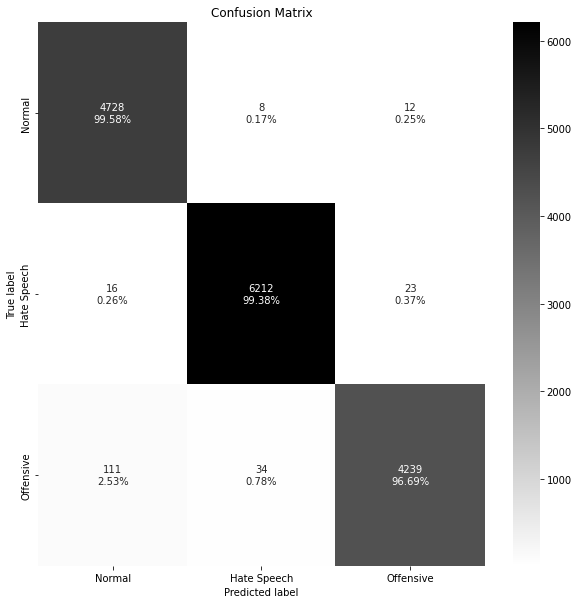

In [11]:
print("Train Data Accuracy: {0:0.2f}".format(accuracy_score(train_output.label_ids, train_output.predictions.argmax(-1))))
    
print(classification_report(train_output.label_ids, train_output.predictions.argmax(-1)))
cf_matrix = confusion_matrix(train_output.label_ids, train_output.predictions.argmax(-1))

label_counts = ["{}".format(value) for value in cf_matrix.flatten()]
label_percents = ["{0:.2%}".format(value / np.sum(row)) for row in cf_matrix for value in row]

box_labels = [f"{v1}\n{v2}\n".strip() for v1, v2 in zip(label_counts,label_percents)]
box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])

plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix, xticklabels=["Normal", "Hate Speech", "Offensive"], yticklabels=["Normal", "Hate Speech", "Offensive"], annot=box_labels, cmap='binary', fmt='')
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Validation Data Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       593
           1       0.73      0.71      0.72       781
           2       0.53      0.52      0.53       548

    accuracy                           0.68      1922
   macro avg       0.67      0.67      0.67      1922
weighted avg       0.68      0.68      0.68      1922



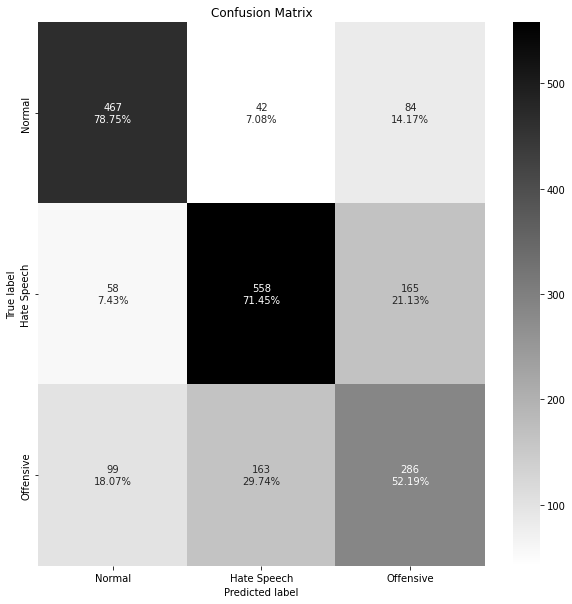

In [12]:
print("Validation Data Accuracy: {0:0.2f}".format(accuracy_score(val_output.label_ids, val_output.predictions.argmax(-1))))
    
print(classification_report(val_output.label_ids, val_output.predictions.argmax(-1)))
cf_matrix = confusion_matrix(val_output.label_ids, val_output.predictions.argmax(-1))

label_counts = ["{}".format(value) for value in cf_matrix.flatten()]
label_percents = ["{0:.2%}".format(value / np.sum(row)) for row in cf_matrix for value in row]

box_labels = [f"{v1}\n{v2}\n".strip() for v1, v2 in zip(label_counts,label_percents)]
box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])

plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix, xticklabels=["Normal", "Hate Speech", "Offensive"], yticklabels=["Normal", "Hate Speech", "Offensive"], annot=box_labels, cmap='binary', fmt='')
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Test Data Accuracy: 0.67
              precision    recall  f1-score   support

           0       0.73      0.78      0.75       594
           1       0.75      0.69      0.72       782
           2       0.51      0.52      0.52       548

    accuracy                           0.67      1924
   macro avg       0.66      0.66      0.66      1924
weighted avg       0.67      0.67      0.67      1924



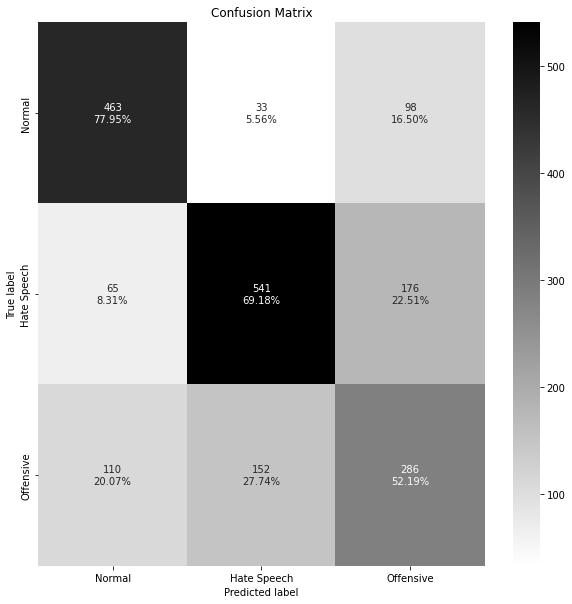

In [13]:
print("Test Data Accuracy: {0:0.2f}".format(accuracy_score(test_output.label_ids, test_output.predictions.argmax(-1))))
    
print(classification_report(test_output.label_ids, test_output.predictions.argmax(-1)))
cf_matrix = confusion_matrix(test_output.label_ids, test_output.predictions.argmax(-1))

label_counts = ["{}".format(value) for value in cf_matrix.flatten()]
label_percents = ["{0:.2%}".format(value / np.sum(row)) for row in cf_matrix for value in row]

box_labels = [f"{v1}\n{v2}\n".strip() for v1, v2 in zip(label_counts,label_percents)]
box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])

plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix, xticklabels=["Normal", "Hate Speech", "Offensive"], yticklabels=["Normal", "Hate Speech", "Offensive"], annot=box_labels, cmap='binary', fmt='')
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Extract labels of the first 20 examples of the test set for manual evaluation

In [7]:
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification, 
                          Trainer, 
                          TrainingArguments)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support


label_extractor = lambda x: max(set(x['label']), key = x['label'].count)
train = {}
train['tokens'] = [' '.join(s) for s in train_ds['post_tokens']]
train['label'] = list(map(label_extractor, train_ds['annotators']))
train_ds = Dataset.from_dict(train)
val = {}
val['tokens'] = [' '.join(s) for s in val_ds['post_tokens']]
val['label'] = list(map(label_extractor, val_ds['annotators']))
val_ds = Dataset.from_dict(val)
test = {}
test['tokens'] = [' '.join(s) for s in test_ds['post_tokens']]
test['label'] = list(map(label_extractor, test_ds['annotators']))
test_ds = Dataset.from_dict(test)


tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
tokenize_func = lambda sentences: tokenizer(sentences['tokens'], \
                                            padding="max_length", \
                                            truncation=True)

tok_train_ds = train_ds.map(tokenize_func, batched=True)
tok_test_ds = test_ds.map(tokenize_func, batched=True)
tok_val_ds = val_ds.map(tokenize_func, batched=True)

model = AutoModelForSequenceClassification.from_pretrained("./DistilRoBERTaTrainedModel", num_labels=3)

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [8]:
trainer = Trainer(
    model=model
)

In [9]:
small_test_ds = torch.utils.data.Subset(tok_test_ds, range(20))

In [10]:
test_output = trainer.predict(test_dataset=small_test_ds)

***** Running Prediction *****
  Num examples = 20
  Batch size = 8


In [11]:
from transformers_interpret import SequenceClassificationExplainer
cls_explainer = SequenceClassificationExplainer(model, tokenizer)

In [12]:
labelToStr = {0: 'Hate Speech', 1: 'Normal', 2: 'Offensive'}
for i in range(20):
  print(f"Sentence: {small_test_ds[i]['tokens']}")
  print(f"RoBERTa label is {labelToStr[test_output.label_ids[i]]}")
  print(f"Because of {cls_explainer(small_test_ds[i]['tokens'])}")

Sentence: <user> men can not be raped can not be abused that why they call it violence against women and children because men are always the perpetrators women come first even before children
RoBERTa label is Normal
Because of [('<s>', 0.0), ('<', 0.12764140529494977), ('user', 0.05067031596269701), ('>', 0.03945189085166884), ('men', -0.38031779635898805), ('can', 0.0284873437756231), ('not', 0.01432157187964113), ('be', -0.016305101448432082), ('raped', 0.04214691104960028), ('can', 0.05117633794949318), ('not', 0.11528983065802442), ('be', 0.04448660478173231), ('abused', 0.4508787135047931), ('that', 0.004136403491523988), ('why', 0.12233400952441692), ('they', 0.019546934486194573), ('call', 0.22900882144021537), ('it', -0.006648365799107699), ('violence', 0.22346669681352704), ('against', 0.09255498621953373), ('women', -0.2579452076569207), ('and', 0.06926284951360659), ('children', -0.14671995015602537), ('because', -0.03645049218057938), ('men', 0.0006824920232223025), ('are',